https://www.datacamp.com/tutorial/variational-autoencoders

In [ ]:
pip install torch torchvision matplotlib numpy

Let's walk through the implementation of a VAE step-by-step. First, we must import the libraries:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

Next, we must define the encoder, decoder, and VAE. Here’s the code:

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

We also have to define the loss function. The loss function for VAEs consists of a reconstruction loss and a KL divergence loss. This is how it looks in PyTorch:

In [ ]:
def loss_function(x, x_hat, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

To train the VAE, we will load the MNIST dataset, define the optimizer, and train the model.

In [ ]:
# Hyperparameters
input_dim = 784
hidden_dim = 400
latent_dim = 20
lr = 1e-3
batch_size = 128
epochs = 10
# Data loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Model, optimizer
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)
# Training loop
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, input_dim)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = loss_function(x, x_hat, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 62.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.37MB/s]


Epoch 1, Loss: 164.77366416015624
Epoch 2, Loss: 121.02906300455729
Epoch 3, Loss: 114.30547205403646
Epoch 4, Loss: 111.35841305338542
Epoch 5, Loss: 109.65695748697917
Epoch 6, Loss: 108.47489290364584
Epoch 7, Loss: 107.61939152018229
Epoch 8, Loss: 106.92687361653645
Epoch 9, Loss: 106.43884248046875
Epoch 10, Loss: 106.00000219726563


3. Testing and evaluating the model

After training, we can evaluate the VAE by visualizing the reconstructed outputs and generated samples.

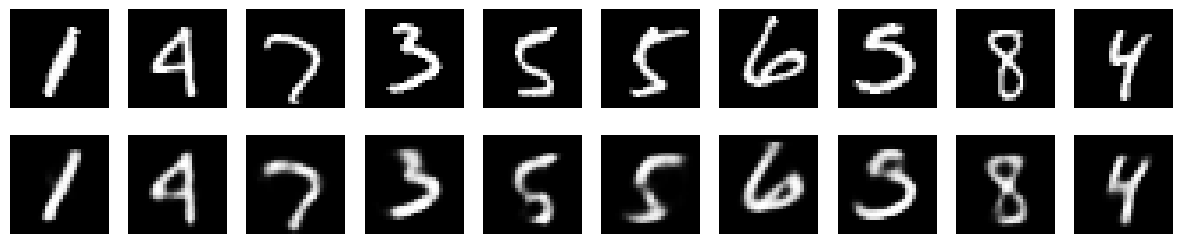

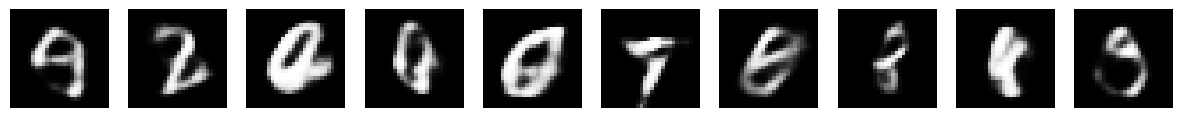

In [ ]:
# visualizing reconstructed outputs
vae.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.view(-1, input_dim)
    x_hat, _, _ = vae(x)
    x = x.view(-1, 28, 28)
    x_hat = x_hat.view(-1, 28, 28)

    fig, axs = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axs[0, i].imshow(x[i].cpu().numpy(), cmap='gray')
        axs[1, i].imshow(x_hat[i].cpu().numpy(), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.show()
#visualizing generated samples
with torch.no_grad():
    z = torch.randn(10, latent_dim)
    sample = vae.decoder(z)
    sample = sample.view(-1, 28, 28)

    fig, axs = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axs[i].imshow(sample[i].cpu().numpy(), cmap='gray')
        axs[i].axis('off')
    plt.show()